In [1]:
# !pip install torchvision
# !pip install torchinfo
# !pip install torchmetrics
# !pip install wandb -qU

We import the necessary packages

In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import torchvision
from torch.utils.data import DataLoader, random_split
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as T
import torch
import torch.nn as nn
from torchvision.utils import make_grid
from torchvision.utils import save_image
from IPython.display import Image
import matplotlib.pyplot as plt
import numpy as np
import random
import torchmetrics
from torchinfo import summary
import torchvision.models as models
from collections import Counter
%matplotlib inline

We initiate gpu and wandb

In [3]:
enable_wandb =  True
use_gpu = True,
gpu_available = torch.cuda.is_available()

if enable_wandb:
  import wandb
  wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: mwangcy0327 (bostonu-ba865). Use `wandb login --relogin` to force relogin


We initiate the configs

In [4]:
configs = {
    "experiment_name": "ViT Transfer Learning",
    "freeze_feature_extraction_layers": True,
    "pretrained":False,
    "efficientnet":False, 
    "data_augmentation":True,
    "transferlearning": True,

    # Data
    "img_dimensions" : (3,224, 224),
    "batch_size" : 64,
    "num_classes" : 5,

    # CNN
    "filter_sizes" : [4,8,16],
    "kernel_size" : 5,
    "stride": 1,
    "padding":0,

    #Optimzation
    "learning_rate" : 0.0001,
    "epochs" : 100,
    "weight_decay" : 0.00001,
    "patience" : 5
}

We load the data and transformations

In [5]:
training_path = "Disease Grading/1. Original Images/a. Training Set"
testing_path = "Disease Grading/1. Original Images/b. Testing Set"

if configs["data_augmentation"]:
    transform = transforms.Compose([
        transforms.RandomHorizontalFlip(0.5),
        transforms.Resize([204, 224]),
        transforms.Pad((0, 10, 0, 10)),
        transforms.RandomRotation(45),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5944, 0.2908, 0.0962], std=[0.2047, 0.1284, 0.0866])
    ])
else:
    transform = transforms.Compose([
        transforms.Resize([224, 224]),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5944, 0.2908, 0.0962], std=[0.2047, 0.1284, 0.0866])
    ])

test_transform = transforms.Compose([
    transforms.Resize(([204, 224])),
    transforms.Pad((0, 10, 0, 10)),
    transforms.ToTensor()
    ])

train_dataset = torchvision.datasets.ImageFolder(training_path, transform = transform)
train_dataset, val_dataset = random_split(train_dataset, [0.8, 0.2])
test_dataset = torchvision.datasets.ImageFolder(testing_path, transform = test_transform)

# Data loaders
train_loader = DataLoader(dataset=train_dataset, batch_size = configs["batch_size"], shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size = configs["batch_size"], shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size = configs["batch_size"], shuffle=False)

We counted the distribution of the data.

In [6]:
from collections import Counter

label_counter = Counter()

for _, label in train_dataset:
    label_counter[label] += 1

print("Label counts in train_dataset:")
for label, count in label_counter.items():
    print(f"Label {label}: {count} occurrences")

Label counts in train_dataset:
Label 0: 108 occurrences
Label 2: 108 occurrences
Label 3: 62 occurrences
Label 4: 36 occurrences
Label 1: 17 occurrences


In [7]:
label_counter = Counter()

for _, label in val_dataset:
    label_counter[label] += 1

print("Label counts in val_dataset:")
for label, count in label_counter.items():
    print(f"Label {label}: {count} occurrences")

Label counts in val_dataset:
Label 0: 26 occurrences
Label 4: 13 occurrences
Label 3: 12 occurrences
Label 2: 28 occurrences
Label 1: 3 occurrences


In [8]:
label_counter = Counter()

for _, label in test_dataset:
    label_counter[label] += 1

print("Label counts in test_dataset:")
for label, count in label_counter.items():
    print(f"Label {label}: {count} occurrences")

Label counts in test_dataset:
Label 0: 34 occurrences
Label 1: 5 occurrences
Label 2: 32 occurrences
Label 3: 19 occurrences
Label 4: 13 occurrences


We calculate the distribution of the testing data to see if the distribution is similar to the training

In [9]:
total_sum = 0
total_sum_squared = 0
total_count = 0

for images, _ in test_loader:
    total_sum += torch.sum(images, dim=(0, 2, 3))
    total_sum_squared += torch.sum(images ** 2, dim=(0, 2, 3))
    total_count += images.size(0) * images.size(2) * images.size(3)

mean = total_sum / total_count
mean_squared = total_sum_squared / total_count

std = torch.sqrt(mean_squared - mean ** 2)

print("Mean pixel values:", mean)
print("Standard deviation of pixel values:", std)

Mean pixel values: tensor([0.3999, 0.1896, 0.0535])
Standard deviation of pixel values: tensor([0.3152, 0.1605, 0.0664])


In [10]:
for images, _ in train_loader:
    print(images.shape)
    break

torch.Size([64, 3, 224, 224])


We plot some of the images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


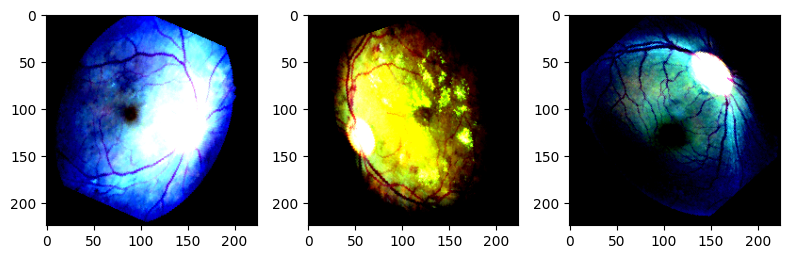

In [11]:
plt.figure(figsize=(8, 8))

iterator = iter(train_loader)
for i in range(3):

    plt.subplot(1, 3, i+1)
    image, _ = next(iterator)
    image_show = image[i].permute(1,2,0)
    plt.imshow(image_show)

plt.tight_layout()
plt.show()

In [12]:
train_dataset[0][0].shape

torch.Size([3, 224, 224])

We import the ViT model

In [13]:
import torchvision

model = torchvision.models.vit_b_16(weights='DEFAULT')

In [14]:
print(model)

VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

We change the last layer to fit our task and then we free all the layers except the last one

In [15]:
model.heads = torch.nn.Sequential(torch.nn.Linear(768, 100), torch.nn.ReLU(), torch.nn.Linear(100, configs["num_classes"]))

if configs["freeze_feature_extraction_layers"] == True:
    for param in model.parameters():
        param.requires_grad = False

    for param in model.heads.parameters():
        param.requires_grad = True

summary(model)

Layer (type:depth-idx)                                            Param #
VisionTransformer                                                 768
├─Conv2d: 1-1                                                     (590,592)
├─Encoder: 1-2                                                    151,296
│    └─Dropout: 2-1                                               --
│    └─Sequential: 2-2                                            --
│    │    └─EncoderBlock: 3-1                                     (7,087,872)
│    │    └─EncoderBlock: 3-2                                     (7,087,872)
│    │    └─EncoderBlock: 3-3                                     (7,087,872)
│    │    └─EncoderBlock: 3-4                                     (7,087,872)
│    │    └─EncoderBlock: 3-5                                     (7,087,872)
│    │    └─EncoderBlock: 3-6                                     (7,087,872)
│    │    └─EncoderBlock: 3-7                                     (7,087,872)
│    │    └─EncoderBlo

We load the weights obtained from previous training in order to prevent retraining the model

In [16]:
model.load_state_dict(torch.load('model_ViT_weights.pth'))

<All keys matched successfully>

We define the functions needed to run the model

In [17]:
def get_accuracy(dataloader, model):
  device = 'cuda' if torch.cuda.is_available() else 'cpu'
  acc = torchmetrics.Accuracy(task = "multiclass", num_classes = configs["num_classes"]).to(device)

  with torch.no_grad():
      for images, labels in dataloader:
          if gpu_available and use_gpu:
            images = images.cuda()
            labels = labels.cuda()

          outputs = model(images) # get predictions

          # Update accuracy for this batch
          acc.update(outputs, labels)


      # Compute the accuracy
      acc = acc.compute()

      return acc

def get_loss(loader):
  with torch.no_grad(): # Anything under torch.no_grad will be calculated with no gradients. Can only be used for testing, not training!

    loss = 0
    for i, (images, labels) in enumerate(loader): # The batches.
          # step1: Move data to cuda. Make sure the model is on cuda too!
          if gpu_available and use_gpu:
            images = images.cuda()
            labels = labels.cuda()

          # step2: Forward pass
          outputs = model(images)

          # step 3: calculate the loss.
          loss = loss + criterion(outputs, labels)
    return loss/ len(loader)

class EarlyStopper:
    def __init__(self, patience=1):
        self.patience = patience
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, validation_loss):
        # If the new loss is lower than the old loss, reset the counter!
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
            # Keep track of the best model by saving it on the hard drive.
            torch.save(model.state_dict(), "./best_model.pt")
        # otherwise, increment the counter.
        elif validation_loss > self.min_validation_loss:
            self.counter += 1
            # If there has been too many epochs with the loss being high, terminate.
            if self.counter >= self.patience:
                return True
        return False

We initialized the criterion and the optimizer

In [18]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=configs["learning_rate"], weight_decay=configs["weight_decay"])

We initiated a run on W&B by specifying the project name, along with the name and configurations.

In [19]:
if enable_wandb:
  wandb.init(
    project= "BA865 Project Neural Networks Report",
    name=configs["experiment_name"],
    config=configs)

if gpu_available and use_gpu:
  model = model.cuda()

We fine tune the model

In [ ]:
early_stopper = EarlyStopper(patience = configs["patience"])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.3, patience=3)

# Training loop
for epoch in range(configs["epochs"]): # The epochs.
    for i, (images, labels) in enumerate(train_loader): # The batches.
        # step 1: Zero out the gradients.
        optimizer.zero_grad()

        # step 1.1 move data to cuda. Make sure the model is on cuda too!
        if gpu_available and use_gpu:
          images = images.cuda()
          labels = labels.cuda()

        # step2: Forward pass
        outputs = model(images)

        # step 3: calculate the loss.
        loss = criterion(outputs, labels)

        # step 4: Backward pass
        loss.backward()
        optimizer.step()

        # Print the loss
        if i %2 == 0:
          print("Epoch", epoch+ 1, " batch", i+1, ". Training Loss: ", loss.item())
          if enable_wandb:
            wandb.log({"loss": loss})

    # Compute total train accuracy
    train_acc = get_accuracy(train_loader, model)
    test_acc = get_accuracy(val_loader, model)

    validation_loss = get_loss(val_loader)
    wandb.log({"val_loss": validation_loss})

    print(f'Epoch [{epoch + 1}/{configs["epochs"]}], LR: {optimizer.param_groups[0]["lr"]}, Validation Loss: {validation_loss.item():.4f}, Train Accuracy: {train_acc.item():.4f}, Validation Accuracy: {test_acc.item():.4f}')
    if enable_wandb:
      wandb.log({"epoch": epoch + 1, "LR": {optimizer.param_groups[0]['lr']}, "train_accuracy": train_acc.item(), "val_accuracy": test_acc.item()})
      
      predictions = []
    
      with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs.cuda()) 
            _, predicted = torch.max(outputs, 1)
            predictions.extend(predicted.tolist())  # Append predictions to the list
    
      wandb.log({"conf_mat": wandb.plot.confusion_matrix(probs=None, 
                                                    y_true=test_loader.dataset.targets, 
                                                    preds=predictions, 
                                                    class_names=test_loader.dataset.classes)})
    
    
    
    scheduler.step(validation_loss)

    if early_stopper.early_stop(validation_loss):
        print("Validation loss hasn't dropped. Early stopping!")
        break

Epoch 1  batch 1 . Training Loss:  0.82487952709198
Epoch 1  batch 3 . Training Loss:  0.7425585985183716
Epoch 1  batch 5 . Training Loss:  0.7655234932899475
Epoch [1/100], LR: 0.0001, Validation Loss: 0.8517, Train Accuracy: 0.7009, Validation Accuracy: 0.6707
Epoch 2  batch 1 . Training Loss:  0.7676689028739929
Epoch 2  batch 3 . Training Loss:  0.7320079207420349
Epoch 2  batch 5 . Training Loss:  0.784878134727478
Epoch [2/100], LR: 0.0001, Validation Loss: 0.8093, Train Accuracy: 0.6798, Validation Accuracy: 0.6829
Epoch 3  batch 1 . Training Loss:  0.6881392598152161
Epoch 3  batch 3 . Training Loss:  0.792499840259552
Epoch 3  batch 5 . Training Loss:  0.739162266254425
Epoch [3/100], LR: 0.0001, Validation Loss: 0.8466, Train Accuracy: 0.7160, Validation Accuracy: 0.6463
Epoch 4  batch 1 . Training Loss:  0.7505998611450195
Epoch 4  batch 3 . Training Loss:  0.7307459115982056
Epoch 4  batch 5 . Training Loss:  0.7392995357513428
Epoch [4/100], LR: 0.0001, Validation Loss: 0

In [ ]:
if enable_wandb:
  wandb.finish()

We print the test accuracy for the model 

In [ ]:
test_accuracy = get_accuracy(test_loader, model)
print(f'Test Accuracy: {test_accuracy.item():.4f}')

We save the last weights that we obtained from training the model

In [ ]:
weights_path = 'model_ViT_weights.pth'

# Save the model weights
torch.save(model.state_dict(), weights_path)